In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import xarray as xr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [2]:
# 这里加载你的数据
data = xr.open_dataset('C:\\Data\\ERA5.nc')

In [3]:
# 下面是加载数据的示例。
lat = data['latitude'].values
lon = data['longitude'].values
level = data['level'].values
time = data['time']
sh= data['q']
v= data['v']

In [4]:
sh

<xarray.DataArray 'q' (time: 540, level: 6, latitude: 361, longitude: 1440)>
[1684281600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 500 550 600 650 700 750
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-12-01
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity

In [5]:
v

<xarray.DataArray 'v' (time: 540, level: 6, latitude: 361, longitude: 1440)>
[1684281600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 500 550 600 650 700 750
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-12-01
Attributes:
    units:          m s**-1
    long_name:      V component of wind
    standard_name:  northward_wind

In [6]:
print(time.values)

['1979-01-01T00:00:00.000000000' '1979-02-01T00:00:00.000000000'
 '1979-03-01T00:00:00.000000000' '1979-04-01T00:00:00.000000000'
 '1979-05-01T00:00:00.000000000' '1979-06-01T00:00:00.000000000'
 '1979-07-01T00:00:00.000000000' '1979-08-01T00:00:00.000000000'
 '1979-09-01T00:00:00.000000000' '1979-10-01T00:00:00.000000000'
 '1979-11-01T00:00:00.000000000' '1979-12-01T00:00:00.000000000'
 '1980-01-01T00:00:00.000000000' '1980-02-01T00:00:00.000000000'
 '1980-03-01T00:00:00.000000000' '1980-04-01T00:00:00.000000000'
 '1980-05-01T00:00:00.000000000' '1980-06-01T00:00:00.000000000'
 '1980-07-01T00:00:00.000000000' '1980-08-01T00:00:00.000000000'
 '1980-09-01T00:00:00.000000000' '1980-10-01T00:00:00.000000000'
 '1980-11-01T00:00:00.000000000' '1980-12-01T00:00:00.000000000'
 '1981-01-01T00:00:00.000000000' '1981-02-01T00:00:00.000000000'
 '1981-03-01T00:00:00.000000000' '1981-04-01T00:00:00.000000000'
 '1981-05-01T00:00:00.000000000' '1981-06-01T00:00:00.000000000'
 '1981-07-01T00:00:00.000

In [7]:
# Extract pressure levels
pressure_levels = [500, 550, 600, 650, 700, 750]

# Initialize water vapor flux array
water_vapor_flux = np.full((len(data.time), len(pressure_levels)-1, len(data.latitude), len(data.longitude)), np.nan)
# Iterate over pressure levels from 500 hPa to 700 hPa
for i in range(len(pressure_levels) - 1):
    print(pressure_levels[i])
    # Get specific humidity and v component at current and next pressure levels
    q_i = sh.sel(level=pressure_levels[i])
    q_i_plus_1 = sh.sel(level=pressure_levels[i + 1])
    v_i = v.sel(level=pressure_levels[i])
    v_i_plus_1 = v.sel(level=pressure_levels[i + 1])
    
    # Calculate water vapor flux
    flux = (q_i * v_i + q_i_plus_1 * v_i_plus_1) * (pressure_levels[i] - pressure_levels[i + 1] )
    water_vapor_flux[:, i, :, :] = flux.values

500
550
600
650
700


In [8]:
# Create an xarray DataArray for water vapor flux
water_vapor_flux_da = xr.DataArray(
    water_vapor_flux,
    dims=['time', 'level', 'latitude', 'longitude'],
    coords={'time': data.time, 'level': pressure_levels[:-1], 'latitude': data.latitude, 'longitude': data.longitude},
    attrs={'units': 'kg m-1 s-1', 'long_name': 'Water Vapor Flux'}
)

print("Water Vapor Flux:")
print(water_vapor_flux_da)

Water Vapor Flux:
<xarray.DataArray (time: 540, level: 5, latitude: 361, longitude: 1440)>
array([[[[-2.10816069e-07, -2.10816069e-07, -2.10816069e-07, ...,
          -2.10816069e-07, -2.10816069e-07, -2.10816069e-07],
         [-4.93553542e-02, -4.90288846e-02, -4.87035848e-02, ...,
          -5.03252260e-02, -4.99999262e-02, -4.96848412e-02],
         [-5.15605658e-02, -5.12005128e-02, -5.08435592e-02, ...,
          -5.26259951e-02, -5.22690415e-02, -5.19163571e-02],
         ...,
         [ 3.77165526e-01,  3.54966849e-01,  3.34805101e-01, ...,
           4.46419328e-01,  4.27801639e-01,  4.02831346e-01],
         [ 3.69688421e-01,  3.40356201e-01,  3.12423855e-01, ...,
           4.44201887e-01,  4.25419480e-01,  3.99540097e-01],
         [ 3.56976449e-01,  3.22785795e-01,  2.89052069e-01, ...,
           4.39785779e-01,  4.18639451e-01,  3.90511274e-01]],

        [[ 1.35638845e-06,  1.35638845e-06,  1.35638845e-06, ...,
           1.35638845e-06,  1.35638845e-06,  1.35638845e-06

In [9]:
total_water_vapor_flux =  water_vapor_flux_da.sum('level')

In [10]:
total_water_vapor_flux

<xarray.DataArray (time: 540, latitude: 361, longitude: 1440)>
array([[[ 1.49116723e-05,  1.49116723e-05,  1.49116723e-05, ...,
          1.49116723e-05,  1.49116723e-05,  1.49116723e-05],
        [-3.51109650e-01, -3.49009078e-01, -3.46877676e-01, ...,
         -3.57378311e-01, -3.55306674e-01, -3.53237554e-01],
        [-3.52018479e-01, -3.49412862e-01, -3.46770458e-01, ...,
         -3.59819259e-01, -3.57225090e-01, -3.54619190e-01],
        ...,
        [ 2.87830383e+00,  2.83015370e+00,  2.75641814e+00, ...,
          2.98544836e+00,  2.95724481e+00,  2.91473657e+00],
        [ 2.82188830e+00,  2.75278971e+00,  2.67403772e+00, ...,
          2.99857298e+00,  2.94864166e+00,  2.88455001e+00],
        [ 2.75216529e+00,  2.67005402e+00,  2.58744106e+00, ...,
          2.99829879e+00,  2.92604479e+00,  2.84331122e+00]],

       [[-8.79383583e-06, -8.79383583e-06, -8.79383583e-06, ...,
         -8.79383583e-06, -8.79383583e-06, -8.79383583e-06],
        [ 1.56521542e-01,  1.57096121e-01,  1.57700038e-01, ...,
          1.54722907e-01,  1.55320846e-01,  1.55921452e-01],
        [ 1.44014508e-01,  1.45032505e-01,  1.46071017e-01, ...,
          1.40983492e-01,  1.41961254e-01,  1.42979518e-01],
...
        [-8.50310318e-01, -7.60481286e-01, -6.65440340e-01, ...,
         -1.14965904e+00, -1.04724201e+00, -9.49243498e-01],
        [-8.37011771e-01, -7.52521356e-01, -6.74219053e-01, ...,
         -1.10126770e+00, -1.01703683e+00, -9.25710802e-01],
        [-8.34028957e-01, -7.34165553e-01, -6.58075958e-01, ...,
         -1.05971065e+00, -9.96253804e-01, -9.22948260e-01]],

       [[-3.15673152e-05, -3.15673152e-05, -3.15673152e-05, ...,
         -3.15673152e-05, -3.15673152e-05, -3.15673152e-05],
        [ 1.42297778e-01,  1.41096545e-01,  1.39866520e-01, ...,
          1.46014605e-01,  1.44779269e-01,  1.43566031e-01],
        [ 1.45023344e-01,  1.44425370e-01,  1.43883245e-01, ...,
          1.46693962e-01,  1.46129468e-01,  1.45556549e-01],
        ...,
        [-8.13221822e-01, -7.11609782e-01, -5.57455726e-01, ...,
         -7.10587909e-01, -7.23390332e-01, -7.74095906e-01],
        [-6.50259154e-01, -5.05265046e-01, -3.12946513e-01, ...,
         -5.93233157e-01, -5.84337600e-01, -6.23232029e-01],
        [-4.66269657e-01, -2.96109445e-01, -9.93233807e-02, ...,
         -5.06752999e-01, -4.71129315e-01, -4.68970731e-01]]])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-12-01
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

In [11]:
#	North Atlantic Ocean
#min lat 0
#min lon -98.0539
#max lat 68.6387
#max lon 12.0059

total_water_vapor_flux_NAO = total_water_vapor_flux.sel(latitude = slice(68.6387,0), longitude = slice(-98.0539, 12.0059))
max_lat  = total_water_vapor_flux_NAO['latitude'].max()
total_water_vapor_flux_top = total_water_vapor_flux_NAO.sel(latitude = max_lat)
total_water_vapor_flux_top


<xarray.DataArray (time: 540, longitude: 441)>
array([[ 0.97142199,  0.9536791 ,  0.9352339 , ..., -0.47642562,
        -0.44475504, -0.41328342],
       [ 0.60622748,  0.59795748,  0.58866501, ...,  0.23502159,
         0.22488427,  0.21583288],
       [ 0.57639587,  0.55845954,  0.5403362 , ..., -1.66530371,
        -1.67823622, -1.69074985],
       ...,
       [ 1.65351044,  1.65500535,  1.65263835, ...,  1.29972269,
         1.29594934,  1.29320738],
       [ 1.54665992,  1.52359572,  1.49733645, ...,  0.81126226,
         0.79549519,  0.7790593 ],
       [ 0.76173454,  0.76082606,  0.75898377, ..., -0.28518007,
        -0.28769834, -0.2918235 ]])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-12-01
    latitude   float32 68.5
  * longitude  (longitude) float32 -98.0 -97.75 -97.5 -97.25 ... 11.5 11.75 12.0

In [12]:
seasons = {
    'DJF': ('12-01', '02-28'),
    'MAM': ('03-01', '05-31'),
    'JJA': ('06-01', '08-31'),
    'SON': ('09-01', '11-30')
}

In [13]:
# Group the data by seasons using resample() function
seasonal_water_vapor_flux = total_water_vapor_flux.resample(time='QS-DEC', closed='left', label='left').reduce(
    np.sum, dim='time', keep_attrs=True)

seasonal_water_vapor_flux_NAO = total_water_vapor_flux_top.resample(time='QS-DEC', closed='left', label='left').reduce(
    np.sum, dim='time', keep_attrs=True)



# Select time indices for each season
DJF_indices = (seasonal_water_vapor_flux['time.month'] == 12) | (seasonal_water_vapor_flux['time.month'] == 1) | (seasonal_water_vapor_flux['time.month'] == 2)
MAM_indices = (seasonal_water_vapor_flux['time.month'] == 3) | (seasonal_water_vapor_flux['time.month'] == 4) | (seasonal_water_vapor_flux['time.month'] == 5)
JJA_indices = (seasonal_water_vapor_flux['time.month'] == 6) | (seasonal_water_vapor_flux['time.month'] == 7) | (seasonal_water_vapor_flux['time.month'] == 8)
SON_indices = (seasonal_water_vapor_flux['time.month'] == 9) | (seasonal_water_vapor_flux['time.month'] == 10) | (seasonal_water_vapor_flux['time.month'] == 11)

DJF_indices_NAO = (seasonal_water_vapor_flux_NAO['time.month'] == 12) | (seasonal_water_vapor_flux_NAO['time.month'] == 1) | (seasonal_water_vapor_flux_NAO['time.month'] == 2)
MAM_indices_NAO = (seasonal_water_vapor_flux_NAO['time.month'] == 3) | (seasonal_water_vapor_flux_NAO['time.month'] == 4) | (seasonal_water_vapor_flux_NAO['time.month'] == 5)
JJA_indices_NAO = (seasonal_water_vapor_flux_NAO['time.month'] == 6) | (seasonal_water_vapor_flux_NAO['time.month'] == 7) | (seasonal_water_vapor_flux_NAO['time.month'] == 8)
SON_indices_NAO = (seasonal_water_vapor_flux_NAO['time.month'] == 9) | (seasonal_water_vapor_flux_NAO['time.month'] == 10) | (seasonal_water_vapor_flux_NAO['time.month'] == 11)
# Select data for each season using the indices
DJF = seasonal_water_vapor_flux.where(DJF_indices, drop=True)
MAM = seasonal_water_vapor_flux.where(MAM_indices, drop=True)
JJA = seasonal_water_vapor_flux.where(JJA_indices, drop=True)
SON = seasonal_water_vapor_flux.where(SON_indices, drop=True)

DJF_NAO = seasonal_water_vapor_flux_NAO.where(DJF_indices_NAO, drop=True)
MAM_NAO = seasonal_water_vapor_flux_NAO.where(MAM_indices_NAO, drop=True)
JJA_NAO = seasonal_water_vapor_flux_NAO.where(JJA_indices_NAO, drop=True)
SON_NAO = seasonal_water_vapor_flux_NAO.where(SON_indices_NAO, drop=True)

DJF =  DJF.isel(time=slice(1,None))
DJF_NAO =  DJF_NAO.isel(time=slice(1,None))


# Print the resulting xarrays for each season
print("DJF Water Vapor Flux:")
print(DJF)

print("MAM Water Vapor Flux:")
print(MAM)

print("JJA Water Vapor Flux:")
print(JJA)

print("SON Water Vapor Flux:")
print(SON)

DJF Water Vapor Flux:
<xarray.DataArray (time: 45, latitude: 361, longitude: 1440)>
array([[[-2.60380846e-05, -2.60380846e-05, -2.60380846e-05, ...,
         -2.60380846e-05, -2.60380846e-05, -2.60380846e-05],
        [-7.96286705e-01, -7.88420528e-01, -7.80401826e-01, ...,
         -8.19758309e-01, -8.11969636e-01, -8.04179148e-01],
        [-8.03257240e-01, -7.93483060e-01, -7.83756465e-01, ...,
         -8.32350538e-01, -8.22809398e-01, -8.12980857e-01],
        ...,
        [ 2.74694330e+00,  2.70777503e+00,  2.66707935e+00, ...,
          2.82890967e+00,  2.80798709e+00,  2.77765301e+00],
        [ 2.91284503e+00,  2.86706681e+00,  2.83219077e+00, ...,
          3.01664817e+00,  2.98581800e+00,  2.94854221e+00],
        [ 3.06149854e+00,  3.01389636e+00,  2.97460726e+00, ...,
          3.20840058e+00,  3.16172218e+00,  3.11113170e+00]],

       [[-3.70433802e-05, -3.70433802e-05, -3.70433802e-05, ...,
         -3.70433802e-05, -3.70433802e-05, -3.70433802e-05],
        [-9.9817950

In [14]:
# Print the resulting xarrays for each season
print("DJF Water Vapor Flux:")
print(DJF)

print("MAM Water Vapor Flux:")
print(MAM)

print("JJA Water Vapor Flux:")
print(JJA)

print("SON Water Vapor Flux:")
print(SON)

DJF Water Vapor Flux:
<xarray.DataArray (time: 45, latitude: 361, longitude: 1440)>
array([[[-2.60380846e-05, -2.60380846e-05, -2.60380846e-05, ...,
         -2.60380846e-05, -2.60380846e-05, -2.60380846e-05],
        [-7.96286705e-01, -7.88420528e-01, -7.80401826e-01, ...,
         -8.19758309e-01, -8.11969636e-01, -8.04179148e-01],
        [-8.03257240e-01, -7.93483060e-01, -7.83756465e-01, ...,
         -8.32350538e-01, -8.22809398e-01, -8.12980857e-01],
        ...,
        [ 2.74694330e+00,  2.70777503e+00,  2.66707935e+00, ...,
          2.82890967e+00,  2.80798709e+00,  2.77765301e+00],
        [ 2.91284503e+00,  2.86706681e+00,  2.83219077e+00, ...,
          3.01664817e+00,  2.98581800e+00,  2.94854221e+00],
        [ 3.06149854e+00,  3.01389636e+00,  2.97460726e+00, ...,
          3.20840058e+00,  3.16172218e+00,  3.11113170e+00]],

       [[-3.70433802e-05, -3.70433802e-05, -3.70433802e-05, ...,
         -3.70433802e-05, -3.70433802e-05, -3.70433802e-05],
        [-9.9817950

In [15]:
DJF_NAO_sum = DJF_NAO.sum(dim='longitude')
MAM_NAO_sum = MAM_NAO.sum(dim='longitude')
JJA_NAO_sum = JJA_NAO.sum(dim='longitude')
SON_NAO_sum = SON_NAO.sum(dim='longitude')


lat_mask = DJF.latitude > 60
DJF_polar = DJF.where(lat_mask, drop=True)
MAM_polar = MAM.where(lat_mask, drop=True)
JJA_polar = JJA.where(lat_mask, drop=True)
SON_polar = SON.where(lat_mask, drop=True)

DJF_polar_sum = DJF_polar.sum(dim=('longitude', 'latitude'))
MAM_polar_sum = MAM_polar.sum(dim=('longitude', 'latitude'))
JJA_polar_sum = JJA_polar.sum(dim=('longitude', 'latitude'))
SON_polar_sum = SON_polar.sum(dim=('longitude', 'latitude'))

print(DJF_NAO_sum.mean(dim='time')/DJF_polar_sum.mean(dim='time'))
print(MAM_NAO_sum.mean(dim='time')/MAM_polar_sum.mean(dim='time'))
print(JJA_NAO_sum.mean(dim='time')/JJA_polar_sum.mean(dim='time'))
print(SON_NAO_sum.mean(dim='time')/SON_polar_sum.mean(dim='time'))


#print(DJF_polar_sum)


<xarray.DataArray ()>
array(0.01800119)
Coordinates:
    latitude  float32 68.5
<xarray.DataArray ()>
array(0.01609685)
Coordinates:
    latitude  float32 68.5
<xarray.DataArray ()>
array(0.01261783)
Coordinates:
    latitude  float32 68.5
<xarray.DataArray ()>
array(0.01812734)
Coordinates:
    latitude  float32 68.5


In [161]:
# DJF_diff =  DJF.diff(dim='time')
# MAM_diff =  MAM.diff(dim='time')
# JJA_diff =  JJA.diff(dim='time')
# SON_diff =  SON.diff(dim='time')

In [162]:
# DJF_diff

<xarray.DataArray (time: 44, latitude: 361, longitude: 1440)>
array([[[-1.10052956e-05, -1.10052956e-05, -1.10052956e-05, ...,
         -1.10052956e-05, -1.10052956e-05, -1.10052956e-05],
        [-2.01892800e-01, -2.05755914e-01, -2.09749205e-01, ...,
         -1.89867366e-01, -1.93873046e-01, -1.97969179e-01],
        [-2.04012321e-01, -2.08289281e-01, -2.12469229e-01, ...,
         -1.90837533e-01, -1.95249047e-01, -1.99604359e-01],
        ...,
        [ 1.49117153e+00,  1.51439659e+00,  1.53475065e+00, ...,
          1.62066312e+00,  1.53561765e+00,  1.49090330e+00],
        [ 1.39460273e+00,  1.39900060e+00,  1.39869682e+00, ...,
          1.53309651e+00,  1.46153213e+00,  1.41178799e+00],
        [ 1.37365836e+00,  1.35178216e+00,  1.33081108e+00, ...,
          1.42855418e+00,  1.41350780e+00,  1.40318164e+00]],

       [[ 1.56081472e-05,  1.56081472e-05,  1.56081472e-05, ...,
          1.56081472e-05,  1.56081472e-05,  1.56081472e-05],
        [-1.37410197e+00, -1.37567649e+00, -1.37700892e+00, ...,
         -1.37037468e+00, -1.37159337e+00, -1.37267904e+00],
        [-1.36774709e+00, -1.36880348e+00, -1.36991865e+00, ...,
         -1.36474875e+00, -1.36580546e+00, -1.36677463e+00],
...
        [-1.27180625e+00, -1.25099922e+00, -1.22739457e+00, ...,
         -1.31171660e+00, -1.29222723e+00, -1.28137358e+00],
        [-1.18544932e+00, -1.16146739e+00, -1.12739053e+00, ...,
         -1.20971653e+00, -1.19940858e+00, -1.19372841e+00],
        [-1.09318556e+00, -1.06520299e+00, -1.02387592e+00, ...,
         -1.11558193e+00, -1.10606431e+00, -1.10247937e+00]],

       [[-4.73100099e-05, -4.73100099e-05, -4.73100099e-05, ...,
         -4.73100099e-05, -4.73100099e-05, -4.73100099e-05],
        [-1.27408502e-01, -1.40084614e-01, -1.52746083e-01, ...,
         -8.94805870e-02, -1.02126896e-01, -1.14776132e-01],
        [-1.71324581e-01, -1.85613695e-01, -1.99875156e-01, ...,
         -1.28933632e-01, -1.43028149e-01, -1.57153105e-01],
        ...,
        [-6.68352004e-01, -5.23094247e-01, -3.34865186e-01, ...,
         -7.37300117e-01, -6.92536510e-01, -6.78615466e-01],
        [-4.07590449e-01, -2.15694272e-01,  5.12184948e-03, ...,
         -5.26819805e-01, -4.55411327e-01, -4.32968509e-01],
        [-1.48160195e-01,  6.27925756e-02,  2.91985075e-01, ...,
         -3.61976389e-01, -2.67448605e-01, -2.06033862e-01]]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1980-12-01 1981-12-01 ... 2023-12-01

In [16]:
from scipy import stats

In [26]:
years = DJF['time.year'].values

# Initialize arrays to store slopes for each latitude and longitude
DJF_slope = np.zeros((DJF.sizes['latitude'], DJF.sizes['longitude']))
MAM_slope = np.zeros((MAM.sizes['latitude'], MAM.sizes['longitude']))
JJA_slope = np.zeros((JJA.sizes['latitude'], JJA.sizes['longitude']))
SON_slope = np.zeros((SON.sizes['latitude'], SON.sizes['longitude']))

DJF_p_value = np.zeros((DJF.sizes['latitude'], DJF.sizes['longitude']))
MAM_p_value = np.zeros((MAM.sizes['latitude'], MAM.sizes['longitude']))
JJA_p_value = np.zeros((JJA.sizes['latitude'], JJA.sizes['longitude']))
SON_p_value = np.zeros((SON.sizes['latitude'], SON.sizes['longitude']))


# Loop over latitude and longitude dimensions
for lat_idx, lat in enumerate(DJF['latitude'].values):
    for lon_idx, lon in enumerate(DJF['longitude'].values):
        # Extract values for the current latitude and longitude
        DJF_values = DJF.sel(latitude=lat, longitude=lon).values*0.018
        MAM_values = MAM.sel(latitude=lat, longitude=lon).values*0.016
        JJA_values = JJA.sel(latitude=lat, longitude=lon).values*0.013
        SON_values = SON.sel(latitude=lat, longitude=lon).values*0.018

        # Ensure the lengths of years and seasonal values are the same
        assert len(years) == DJF_values.shape[0], "Lengths of years and DJF values do not match"
        assert len(years) == MAM_values.shape[0], "Lengths of years and MAM values do not match"
        assert len(years) == JJA_values.shape[0], "Lengths of years and JJA values do not match"
        assert len(years) == SON_values.shape[0], "Lengths of years and SON values do not match"

        # Calculate linear trends for each season at the current latitude and longitude
        DJF_slope[lat_idx, lon_idx], _ = np.polyfit(years, DJF_values, 1)
        MAM_slope[lat_idx, lon_idx], _ = np.polyfit(years, MAM_values, 1)
        JJA_slope[lat_idx, lon_idx], _ = np.polyfit(years, JJA_values, 1)
        SON_slope[lat_idx, lon_idx], _ = np.polyfit(years, SON_values, 1)
        
        _,DJF_p_value[lat_idx, lon_idx] = stats.ttest_ind(years, DJF_values)
        _,MAM_p_value[lat_idx, lon_idx] = stats.ttest_ind(years, MAM_values)
        _,JJA_p_value[lat_idx, lon_idx] = stats.ttest_ind(years, JJA_values)
        _,SON_p_value[lat_idx, lon_idx] = stats.ttest_ind(years, SON_values)

print(DJF_slope)

[[ 6.10162079e-09  6.10162079e-09  6.10162079e-09 ...  6.10162079e-09
   6.10162079e-09  6.10162079e-09]
 [ 4.49532675e-04  4.49186446e-04  4.48796764e-04 ...  4.50581940e-04
   4.50260990e-04  4.49902697e-04]
 [ 4.57792803e-04  4.57426104e-04  4.57038406e-04 ...  4.58810003e-04
   4.58497857e-04  4.58119627e-04]
 ...
 [ 1.25684208e-05  4.18061658e-05  6.60421994e-05 ... -4.02471624e-05
  -3.61806987e-05 -1.64537204e-05]
 [-6.59969166e-05 -3.63615501e-05 -8.16390911e-06 ... -1.12608711e-04
  -1.11660742e-04 -9.30877205e-05]
 [-1.41764991e-04 -1.14029617e-04 -8.79303645e-05 ... -1.81338938e-04
  -1.80804595e-04 -1.65555845e-04]]


In [27]:
print(DJF_p_value)

[[4.48473252e-181 4.48473252e-181 4.48473252e-181 ... 4.48473252e-181
  4.48473252e-181 4.48473252e-181]
 [4.48580136e-181 4.48581522e-181 4.48582908e-181 ... 4.48576020e-181
  4.48577384e-181 4.48578757e-181]
 [4.48589962e-181 4.48591983e-181 4.48594015e-181 ... 4.48583941e-181
  4.48585947e-181 4.48587953e-181]
 ...
 [4.49294712e-181 4.49294211e-181 4.49285616e-181 ... 4.49315133e-181
  4.49304721e-181 4.49295617e-181]
 [4.49307997e-181 4.49304500e-181 4.49295504e-181 ... 4.49332384e-181
  4.49319033e-181 4.49309916e-181]
 [4.49323277e-181 4.49319203e-181 4.49307837e-181 ... 4.49354957e-181
  4.49340479e-181 4.49330262e-181]]


In [28]:
DJF_slope_array = xr.DataArray(DJF_slope, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

MAM_slope_array = xr.DataArray(MAM_slope, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

JJA_slope_array = xr.DataArray(JJA_slope, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

SON_slope_array = xr.DataArray(SON_slope, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

print(DJF_slope_array)

combined_diff = xr.concat([DJF_slope_array, MAM_slope_array, JJA_slope_array, SON_slope_array], dim='season')

<xarray.DataArray (latitude: 361, longitude: 1440)>
array([[ 6.10162079e-09,  6.10162079e-09,  6.10162079e-09, ...,
         6.10162079e-09,  6.10162079e-09,  6.10162079e-09],
       [ 4.49532675e-04,  4.49186446e-04,  4.48796764e-04, ...,
         4.50581940e-04,  4.50260990e-04,  4.49902697e-04],
       [ 4.57792803e-04,  4.57426104e-04,  4.57038406e-04, ...,
         4.58810003e-04,  4.58497857e-04,  4.58119627e-04],
       ...,
       [ 1.25684208e-05,  4.18061658e-05,  6.60421994e-05, ...,
        -4.02471624e-05, -3.61806987e-05, -1.64537204e-05],
       [-6.59969166e-05, -3.63615501e-05, -8.16390911e-06, ...,
        -1.12608711e-04, -1.11660742e-04, -9.30877205e-05],
       [-1.41764991e-04, -1.14029617e-04, -8.79303645e-05, ...,
        -1.81338938e-04, -1.80804595e-04, -1.65555845e-04]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8


In [29]:
DJF_p_value = xr.DataArray(DJF_p_value, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

MAM_p_value = xr.DataArray(MAM_p_value, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

JJA_p_value = xr.DataArray(JJA_p_value, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

SON_p_value = xr.DataArray(SON_p_value, dims=('latitude', 'longitude'),
                              coords={'latitude': data.latitude, 'longitude': data.longitude})

print(DJF_p_value)

combined_diff_p_value = xr.concat([DJF_p_value, MAM_p_value, JJA_p_value, SON_p_value], dim='season')

<xarray.DataArray (latitude: 361, longitude: 1440)>
array([[4.48473252e-181, 4.48473252e-181, 4.48473252e-181, ...,
        4.48473252e-181, 4.48473252e-181, 4.48473252e-181],
       [4.48580136e-181, 4.48581522e-181, 4.48582908e-181, ...,
        4.48576020e-181, 4.48577384e-181, 4.48578757e-181],
       [4.48589962e-181, 4.48591983e-181, 4.48594015e-181, ...,
        4.48583941e-181, 4.48585947e-181, 4.48587953e-181],
       ...,
       [4.49294712e-181, 4.49294211e-181, 4.49285616e-181, ...,
        4.49315133e-181, 4.49304721e-181, 4.49295617e-181],
       [4.49307997e-181, 4.49304500e-181, 4.49295504e-181, ...,
        4.49332384e-181, 4.49319033e-181, 4.49309916e-181],
       [4.49323277e-181, 4.49319203e-181, 4.49307837e-181, ...,
        4.49354957e-181, 4.49340479e-181, 4.49330262e-181]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8


In [30]:
combined_diff_p_value

<xarray.DataArray (season: 4, latitude: 361, longitude: 1440)>
array([[[4.48473252e-181, 4.48473252e-181, 4.48473252e-181, ...,
         4.48473252e-181, 4.48473252e-181, 4.48473252e-181],
        [4.48580136e-181, 4.48581522e-181, 4.48582908e-181, ...,
         4.48576020e-181, 4.48577384e-181, 4.48578757e-181],
        [4.48589962e-181, 4.48591983e-181, 4.48594015e-181, ...,
         4.48583941e-181, 4.48585947e-181, 4.48587953e-181],
        ...,
        [4.49294712e-181, 4.49294211e-181, 4.49285616e-181, ...,
         4.49315133e-181, 4.49304721e-181, 4.49295617e-181],
        [4.49307997e-181, 4.49304500e-181, 4.49295504e-181, ...,
         4.49332384e-181, 4.49319033e-181, 4.49309916e-181],
        [4.49323277e-181, 4.49319203e-181, 4.49307837e-181, ...,
         4.49354957e-181, 4.49340479e-181, 4.49330262e-181]],

       [[4.48473252e-181, 4.48473252e-181, 4.48473252e-181, ...,
         4.48473252e-181, 4.48473252e-181, 4.48473252e-181],
        [4.48360525e-181, 4.48361870e-181, 4.48363224e-181, ...,
         4.48356504e-181, 4.48357839e-181, 4.48359179e-181],
        [4.48370735e-181, 4.48372644e-181, 4.48374554e-181, ...,
         4.48364993e-181, 4.48366907e-181, 4.48368830e-181],
...
        [4.48349171e-181, 4.48355199e-181, 4.48358848e-181, ...,
         4.48330522e-181, 4.48336038e-181, 4.48342189e-181],
        [4.48366941e-181, 4.48372108e-181, 4.48376055e-181, ...,
         4.48352814e-181, 4.48355386e-181, 4.48362251e-181],
        [4.48383638e-181, 4.48390050e-181, 4.48393007e-181, ...,
         4.48374403e-181, 4.48376397e-181, 4.48382216e-181]],

       [[4.48473252e-181, 4.48473252e-181, 4.48473252e-181, ...,
         4.48473252e-181, 4.48473252e-181, 4.48473252e-181],
        [4.48607509e-181, 4.48607590e-181, 4.48607672e-181, ...,
         4.48607262e-181, 4.48607337e-181, 4.48607435e-181],
        [4.48646443e-181, 4.48647331e-181, 4.48648207e-181, ...,
         4.48643712e-181, 4.48644628e-181, 4.48645547e-181],
        ...,
        [4.48356294e-181, 4.48364503e-181, 4.48372771e-181, ...,
         4.48343290e-181, 4.48345477e-181, 4.48349554e-181],
        [4.48373127e-181, 4.48380584e-181, 4.48388710e-181, ...,
         4.48362615e-181, 4.48363606e-181, 4.48368530e-181],
        [4.48391449e-181, 4.48399895e-181, 4.48406186e-181, ...,
         4.48384490e-181, 4.48385914e-181, 4.48389068e-181]]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Dimensions without coordinates: season

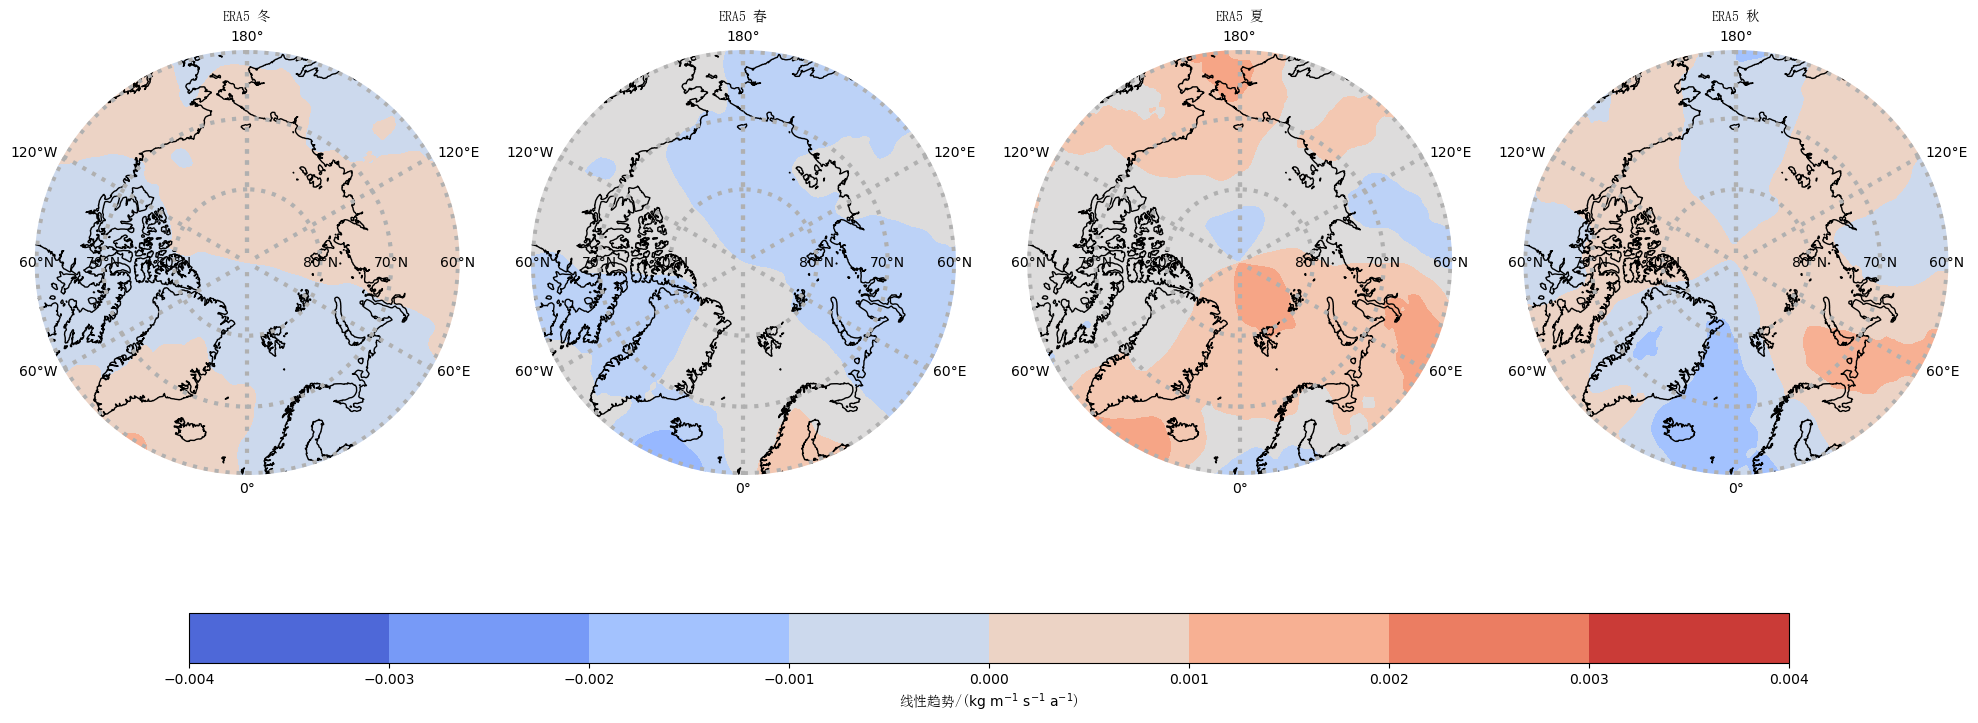

In [53]:
import matplotlib.path as mpath
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10), subplot_kw={'projection': ccrs.Orthographic(central_latitude = 90, central_longitude= 0, globe=None)})#{'projection': ccrs.NorthPolarStereo()}dict(projection='polar')
# Iterate over each subplot
seasons = ['冬', '春', '夏', '秋']
for i, ax in enumerate(axs):
    # Add coastlines to each subplot
    
    ax.coastlines()

    # Create filled contour plot
    contour = ax.contourf(data.longitude, data.latitude, combined_diff[i,:,:], transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.gridlines(draw_labels=True,rotate_labels=False,lw=3,ls=':',ylocs=range(60,90,10),y_inline=True)
    # Set title
    ax.set_title(f'ERA5 {seasons[i]}', fontproperties='SimSun')
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    r_limit = 3214068.5
    r_extent = r_limit*1.0001
    ax.set_xlim(-r_extent, r_extent)
    ax.set_ylim(-r_extent, r_extent)

    # Prep circular boundary
    circle_path = mpath.Path.unit_circle()
    circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())
    
    #set circle boundary
    ax.set_boundary(circle_path)
    #hide frame
    ax.set_frame_on(False)  #hide the rectangle frame
     
plt.tight_layout()  # Adjust subplot layout to prevent overlap
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])
cbar = fig.colorbar(contour, cax=cbar_ax,orientation="horizontal")

# Create colorbar
#cbar = fig.colorbar(contour, cax=cax, orientation='horizontal')
cbar.set_label(r'线性趋势/($\mathrm{kg\ m^{-1}\ s^{-1}\ a^{-1}}$)', fontproperties='SimSun')

plt.savefig('output_figure.png')
plt.show()

In [52]:
plt.savefig('output_figure.png')
plt.show()

<Figure size 640x480 with 0 Axes>

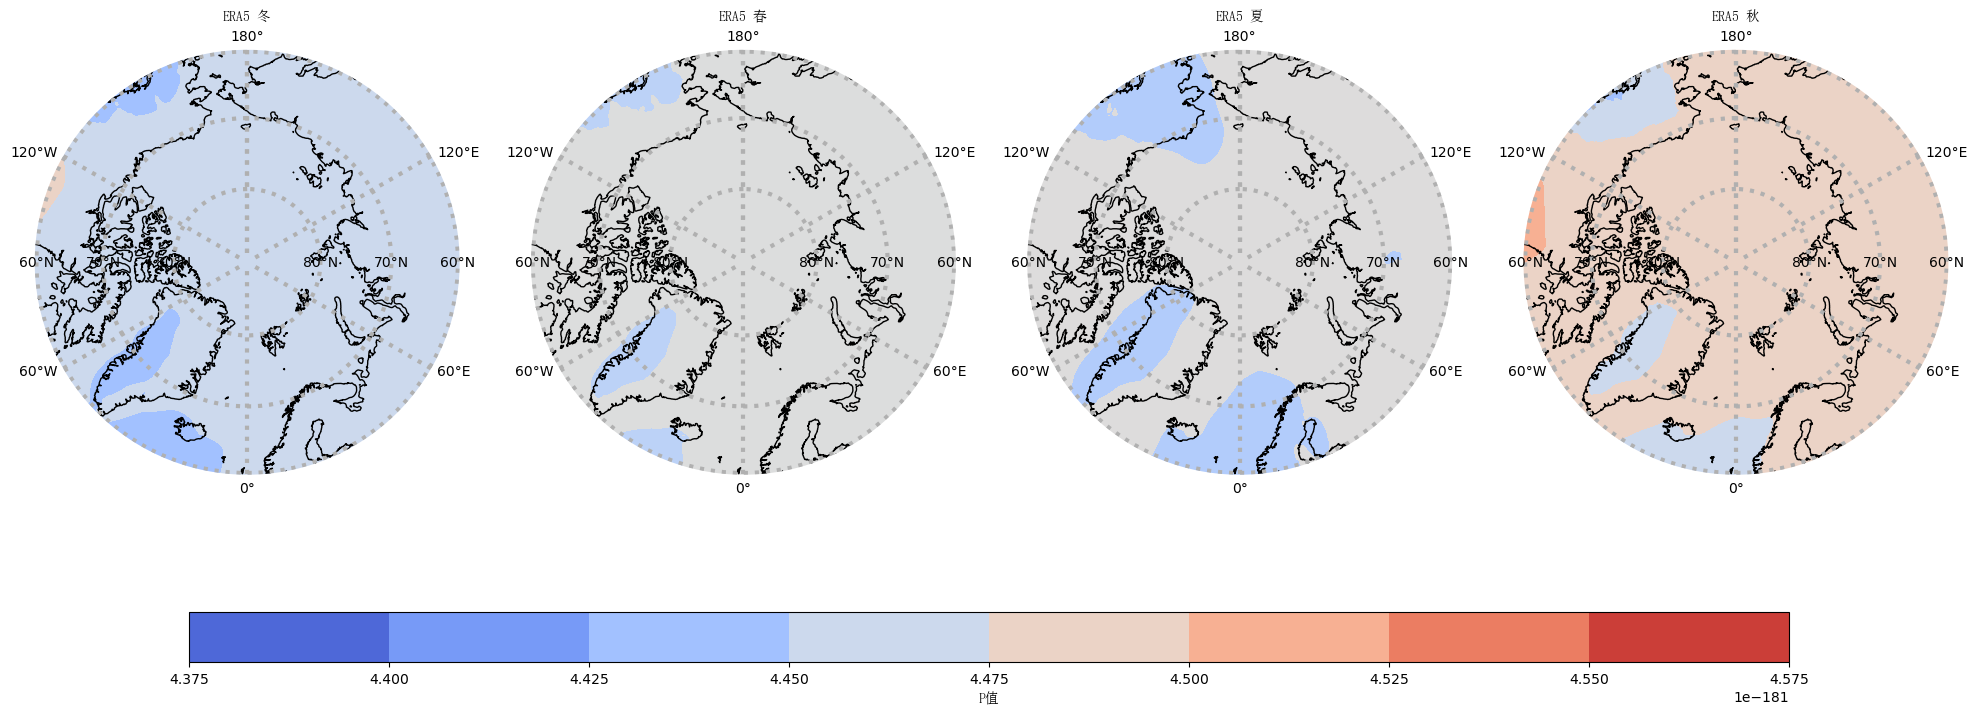

In [31]:
import matplotlib.path as mpath
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10), subplot_kw={'projection': ccrs.Orthographic(central_latitude = 90, central_longitude= 0, globe=None)})#{'projection': ccrs.NorthPolarStereo()}dict(projection='polar')
# Iterate over each subplot
seasons = ['冬', '春', '夏', '秋']
for i, ax in enumerate(axs):
    # Add coastlines to each subplot
    
    ax.coastlines()

    # Create filled contour plot
    contour = ax.contourf(data.longitude, data.latitude, combined_diff_p_value[i,:,:], transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.gridlines(draw_labels=True,rotate_labels=False,lw=3,ls=':',ylocs=range(60,90,10),y_inline=True)
    # Set title
    ax.set_title(f'ERA5 {seasons[i]}', fontproperties='SimSun')
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    r_limit = 3214068.5
    r_extent = r_limit*1.0001
    ax.set_xlim(-r_extent, r_extent)
    ax.set_ylim(-r_extent, r_extent)

    # Prep circular boundary
    circle_path = mpath.Path.unit_circle()
    circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())
    
    #set circle boundary
    ax.set_boundary(circle_path)
    #hide frame
    ax.set_frame_on(False)  #hide the rectangle frame
     
plt.tight_layout()  # Adjust subplot layout to prevent overlap
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])
cbar = fig.colorbar(contour, cax=cbar_ax,orientation="horizontal")

# Create colorbar
#cbar = fig.colorbar(contour, cax=cax, orientation='horizontal')
cbar.set_label(r'P值', fontproperties='SimSun')

plt.savefig('output_figure.png')
plt.show()

In [ ]:
plt.savefig('p_value.png')
plt.show()